# Fashion Image Search Engine

![](https://wwd.com/wp-content/uploads/2017/10/nyfwssd301-nocrop-w840-h1330-2x-1.jpg?w=910&h=511&crop=1)

***
In this project, I build a Fashion Image Search Engine (also called, Content Based Recommender Engine or CBR) using Tensorflow and Keras. In this project you will learn the following:

* Convolutional Neural Network
* Transfer Learning
* Architectures of ResNet 50, VGG 16 & Xception
* Image Similarity

I will be posting a blog post on this project as well on my website, you can check it out [here](https://keepingupwithdatascience.wordpress.com/).
***

In [114]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from random import sample
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess
from tensorflow.keras.models import Model
from pathlib import Path
Image.LOAD_TRUNCATED_IMAGES = True
import requests
from io import BytesIO
import os

In [115]:
# Read the data files
listing_data = pd.read_csv("../input/farfetch-listings/current_farfetch_listings.csv")

# Data Analysis

In [116]:
listing_data.head()

,Unnamed: 0,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,...,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.installmentsLabel,priceInfo.isOnSale,shortDescription,stockTotal
0,0,NaN,8360,Miu Miu,women,True,13415450,https://cdn-images.farfetch-contents.com/13/41...,https://cdn-images.farfetch-contents.com/13/41...,False,...,SGD,NaN,1080,"$1,080","$1,080",1080,NaN,False,logo print strap sandals,130
1,1,"[{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...",2049368,Self-Portrait,women,True,13784566,https://cdn-images.farfetch-contents.com/13/78...,https://cdn-images.farfetch-contents.com/13/78...,False,...,SGD,20% Off,392,$392,$490,490,NaN,True,embroidered midi dress,14
2,2,NaN,15514,Fendi,women,True,13377441,https://cdn-images.farfetch-contents.com/13/37...,https://cdn-images.farfetch-contents.com/13/37...,False,...,SGD,NaN,1245,"$1,245","$1,245",1245,NaN,False,FendiMania sock style sneakers,68
3,3,"[{'scaleId': 0, 'size': 'One Size'}]",49486,A.P.C.,women,False,13744082,https://cdn-images.farfetch-contents.com/13/74...,https://cdn-images.farfetch-contents.com/13/74...,False,...,SGD,20% Off,308,$308,$385,385,NaN,True,top zip wallet,1
4,4,NaN,34624,Prada,women,True,13668256,https://cdn-images.farfetch-contents.com/13/66...,https://cdn-images.farfetch-contents.com/13/66...,False,...,SGD,NaN,1248,"$1,248","$1,248",1248,NaN,False,slingback 65 pumps,78


In [117]:
# Check the shape of data (num_rows, num_colums)
listing_data.shape

(188817, 23)

In [118]:
# drop the unnames: 0 column
listing_data.drop('Unnamed: 0', axis=1, inplace=True)

In [119]:
# Check for dtypes
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188817 entries, 0 to 188816
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   availableSizes                   162711 non-null  object 
 1   brand.id                         188817 non-null  int64  
 2   brand.name                       188817 non-null  object 
 3   gender                           188817 non-null  object 
 4   hasSimilarProducts               188817 non-null  bool   
 5   id                               188817 non-null  int64  
 6   images.cutOut                    188817 non-null  object 
 7   images.model                     188817 non-null  object 
 8   isCustomizable                   188817 non-null  bool   
 9   merchandiseLabel                 56441 non-null   object 
 10  merchandiseLabelField            188817 non-null  object 
 11  merchantId                       188817 non-null  int64  
 12  pr

* Has priceInfo.installmentsLabel all null values.

In [120]:
# Drop priceInfo.installmentsLabel
listing_data.drop('priceInfo.installmentsLabel', axis=1, inplace=True)

In [121]:
# Check for % of null values
listing_data.isnull().sum() * 100 / listing_data.shape[0] 

availableSizes                     13.826086
brand.id                            0.000000
brand.name                          0.000000
gender                              0.000000
hasSimilarProducts                  0.000000
id                                  0.000000
images.cutOut                       0.000000
images.model                        0.000000
isCustomizable                      0.000000
merchandiseLabel                   70.108094
merchandiseLabelField               0.000000
merchantId                          0.000000
priceInfo.currencyCode              0.000000
priceInfo.discountLabel            63.834295
priceInfo.finalPrice                0.000000
priceInfo.formattedFinalPrice       0.000000
priceInfo.formattedInitialPrice     0.000000
priceInfo.initialPrice              0.000000
priceInfo.isOnSale                  0.000000
shortDescription                    0.000000
stockTotal                          0.000000
dtype: float64

In [122]:
# Analyse the null variables
listing_data[~listing_data['merchandiseLabel'].isnull()].head()

,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabel,...,merchantId,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
9,"[{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...",1504165,Rejina Pyo,women,True,13777585,https://cdn-images.farfetch-contents.com/13/77...,https://cdn-images.farfetch-contents.com/13/77...,False,New Season,...,9359,SGD,NaN,989,$989,$989,989,False,Blake herringbone midi dress,16
11,"[{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...",2747,Chloé,women,True,13704528,https://cdn-images.farfetch-contents.com/13/70...,https://cdn-images.farfetch-contents.com/13/70...,False,New Season,...,9359,SGD,NaN,1790,"$1,790","$1,790",1790,False,pussy-bow rose-jacquard blouse,14
13,"[{'scaleId': 0, 'size': 'L'}, {'scaleId': 0, '...",168996,Pleats Please By Issey Miyake,women,True,14107224,https://cdn-images.farfetch-contents.com/14/10...,https://cdn-images.farfetch-contents.com/14/10...,False,New Season,...,9359,SGD,NaN,657,$657,$657,657,False,pleated midi dress,13
15,NaN,769627,Burberry,women,True,13970008,https://cdn-images.farfetch-contents.com/13/97...,https://cdn-images.farfetch-contents.com/13/97...,False,New Season,...,9359,SGD,NaN,1000,"$1,000","$1,000",1000,False,Margrette 50mm cow print pumps,10
18,"[{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...",2765,Alexander McQueen,women,True,13951735,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,New Season,...,9359,SGD,NaN,3330,"$3,330","$3,330",3330,False,tie-neck houndstooth midi-dress,2


In [123]:
# Check for the categories in merchandiseLabel
listing_data['merchandiseLabel'].value_counts()

New Season              41469
Positively Conscious    12324
Permanent Collection     1275
Seasonal Pick             741
Exclusive                 632
Name: merchandiseLabel, dtype: int64

In [124]:
# Drop the column merchandiseLabel
listing_data.drop('merchandiseLabel', axis=1, inplace=True)

In [125]:
# Analysing priceInfo.discountLabel
listing_data[listing_data['priceInfo.discountLabel'].isnull()].head()

,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,NaN,8360,Miu Miu,women,True,13415450,https://cdn-images.farfetch-contents.com/13/41...,https://cdn-images.farfetch-contents.com/13/41...,False,NoTag,9359,SGD,NaN,1080,"$1,080","$1,080",1080,False,logo print strap sandals,130
2,NaN,15514,Fendi,women,True,13377441,https://cdn-images.farfetch-contents.com/13/37...,https://cdn-images.farfetch-contents.com/13/37...,False,NoTag,9140,SGD,NaN,1245,"$1,245","$1,245",1245,False,FendiMania sock style sneakers,68
4,NaN,34624,Prada,women,True,13668256,https://cdn-images.farfetch-contents.com/13/66...,https://cdn-images.farfetch-contents.com/13/66...,False,NoTag,9339,SGD,NaN,1248,"$1,248","$1,248",1248,False,slingback 65 pumps,78
6,"[{'scaleId': 0, 'size': 'One Size'}]",25354,Gucci,women,True,12562558,https://cdn-images.farfetch-contents.com/12/56...,https://cdn-images.farfetch-contents.com/12/56...,False,NoTag,10952,SGD,NaN,3740,"$3,740","$3,740",3740,False,Green Dionysus GG small velvet shoulder bag,61
7,"[{'scaleId': 0, 'size': 'One Size'}]",1025204,MCM,women,True,13768073,https://cdn-images.farfetch-contents.com/13/76...,https://cdn-images.farfetch-contents.com/13/76...,False,NoTag,9913,SGD,NaN,1323,"$1,323","$1,323",1323,False,logo print satchel,5


* The null values in priceInfo.discountLabel indicate that there is no discount.

In [126]:
# fill the null values in priceInfo.discountLabel with 0
listing_data['priceInfo.discountLabel'] = listing_data['priceInfo.discountLabel'].fillna(0)

In [127]:
# drop the size column
listing_data.drop('availableSizes', axis=1, inplace=True)

In [128]:
# Check for null values again
listing_data.isnull().sum()

brand.id                           0
brand.name                         0
gender                             0
hasSimilarProducts                 0
id                                 0
images.cutOut                      0
images.model                       0
isCustomizable                     0
merchandiseLabelField              0
merchantId                         0
priceInfo.currencyCode             0
priceInfo.discountLabel            0
priceInfo.finalPrice               0
priceInfo.formattedFinalPrice      0
priceInfo.formattedInitialPrice    0
priceInfo.initialPrice             0
priceInfo.isOnSale                 0
shortDescription                   0
stockTotal                         0
dtype: int64

In [129]:
# Extracting the Image 
def load_images():
    
    # Store the directory path in a varaible
    cutout_img_dir = "../input/farfetch-listings/cutout-img/cutout"
    model_img_dir = "../input/farfetch-listings/model-img/model"
    
    # list the images in these directories
    cutout_images = os.listdir(cutout_img_dir)
    model_images = os.listdir(model_img_dir)
    
    # load 10 Random Cutout Images: Sample out 10 images randomly from the above list
    sample_cutout_images = sample(cutout_images,10)
    fig = plt.figure(figsize=(10, 5))
    
    print("==============Cutout Images==============")
    for i, img_name in enumerate(sample_cutout_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(cutout_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()
    print()
    # load 10 Random Model Images: Sample out 10 images randomly from the above list
    sample_model_images = sample(model_images,10)
    fig = plt.figure(figsize=(10,5))
    
    print("==============Model Images==============")
    for i, img_name in enumerate(sample_model_images):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(model_img_dir, img_name)
        loaded_img = image.load_img(img_path)
        img_array = image.img_to_array(loaded_img, dtype='int')
        plt.imshow(img_array)
        plt.axis('off')
        
    plt.show()

==============Cutout Images==============


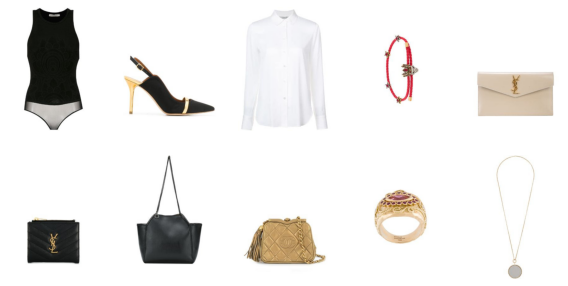


==============Model Images==============


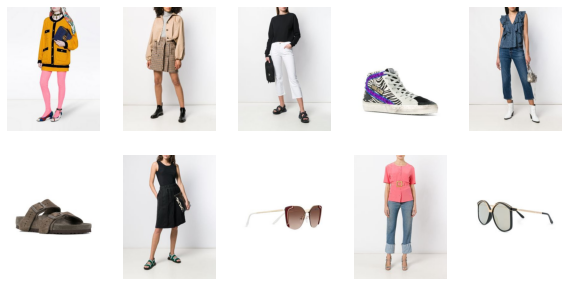

In [130]:
load_images()

In [131]:
# Join the images with path and add in the dataframe

# Store the directory path in a varaible
cutout_img_dir = "../input/farfetch-listings/cutout-img/cutout"
model_img_dir = "../input/farfetch-listings/model-img/model"

# list the directories
cutout_images = os.listdir(cutout_img_dir)
model_images = os.listdir(model_img_dir)

In [132]:
def extractImageName(x):
    
    # 1. Invert the image path
    x_inv = x[ :: -1]
    
    # 2. Find the index of '/'
    slash_idx = x_inv.find('/')
    
    # 3. Extract the text after the -slash_idx
    return x[-slash_idx : ] 

listing_data['cutOutimageNames'] = listing_data['images.cutOut'].apply(lambda x : extractImageName(x))
listing_data['modelimageNames'] = listing_data['images.model'].apply(lambda x : extractImageName(x))

In [133]:
# Extract only those data points for which we have images
listing_data = listing_data[listing_data['cutOutimageNames'].isin(cutout_images)]
listing_data = listing_data[listing_data['modelimageNames'].isin(model_images)]

In [134]:
# Reset the index
listing_data.reset_index(drop=True, inplace=True)

In [135]:
# Add entire paths to cutOut and modelImages
listing_data['cutOutImages_path'] = cutout_img_dir + '/' + listing_data['cutOutimageNames']
listing_data['modelImages_path'] = model_img_dir + '/' + listing_data['modelimageNames']

In [136]:
# Drop the cutOutimageNames, cutOutimageNames
listing_data.drop(['cutOutimageNames', 'cutOutimageNames'], axis=1, inplace=True)

The images show a long sleeve sheer body
Price: $300
Brand: Ann Demeulemeester



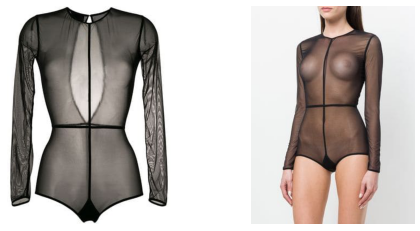

In [137]:
# Plot the images along with product descriptions, price and brand
random_idx = np.random.randint(low = 0, high = listing_data.shape[0] - 1)
cutOut_img_path = listing_data.iloc[random_idx]['cutOutImages_path']
model_img_path = listing_data.iloc[random_idx]['modelImages_path']
price = listing_data.iloc[random_idx]['priceInfo.formattedFinalPrice']
desc = listing_data.iloc[random_idx]['shortDescription']
brand = listing_data.iloc[random_idx]['brand.name']

# Load the images
cutOut_img = image.load_img(cutOut_img_path)
cutOut_img_arr = image.img_to_array(cutOut_img, dtype='int')
model_img = image.load_img(model_img_path)
model_img_arr = image.img_to_array(model_img, dtype='int')

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
print("The images show a {}".format(desc))
print("Price: {}".format(price))
print("Brand: {}".format(brand))
print()
ax[0].imshow(cutOut_img_arr)
ax[1].imshow(model_img_arr)
ax[0].axis('off')
ax[1].axis('off')
plt.show()


# Image Search Engine using Keras and Tensorflow

In [138]:
# Creating a class for feature extraction and finding the most similar images

'''
Comparing 3 different models

1. VGG 16
2. ResNet 50
3. Xception
'''

class FeatureExtractor:
    
    # Constructor
    def __init__(self, arch='VGG'):
        
        self.arch = arch
        
        # Using VGG -16 as the architecture with ImageNet weights
        if self.arch == 'VGG' :
            base_model = VGG16(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('fc1').output)
        
        # Using the ResNet 50 as the architecture with ImageNet weights
        elif self.arch == 'ResNet':
            base_model = ResNet50(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
        
        # Using the Xception as the architecture with ImageNet weights
        elif self.arch == 'Xception':
            base_model = Xception(weights = 'imagenet')
            self.model = Model(inputs = base_model.input, outputs = base_model.get_layer('avg_pool').output)
            
    
    # Method to extract image features
    def extract_features(self, img):
        
        # The VGG 16 & ResNet 50 model has images of 224,244 as input while the Xception has 299, 299
        if self.arch == 'VGG' or self.arch == 'ResNet':
            img = img.resize((224, 224))
        elif self.arch == 'Xception':
            img = img.resize((299, 299))
        
        # Convert the image channels from to RGB
        img = img.convert('RGB')
        
        # Convert into array
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        if self.arch == 'VGG':
            # Proprocess the input as per vgg 16
            x = vgg_preprocess(x)
            
        elif self.arch == 'ResNet':
            # Proprocess the input as per ResNet 50
            x = resnet_preprocess(x)
            
        elif self.arch == 'Xception':
            # Proprocess the input as per ResNet 50
            x = xception_preprocess(x)
        
        
        # Extract the features
        features = self.model.predict(x) 
        
        # Scale the features
        features = features / np.linalg.norm(features)
        
        return features      


## Testing the Feature Extractor

* VGG 19
* ResNet 50
* Xception

In [139]:
# Extract the features for a sample of 10000 images
index_values = np.random.randint(low = 0, high = listing_data.shape[0]-1, size = 10000)
modelImages = listing_data.iloc[index_values]['modelImages_path']

**1. ResNet 50**

***
* ResNet stands for Residual Network. 
* The ResNet 50 is a 50 layer deep network.
* It had a special unit or a special connection called the skip connections, which allowed to train these deep layered models effeciently.
* In the skip connection, the inputs are directly connected to the output layer. Then the network is forced to model h(x) - x, where h(x) hypothesis function and x is the input. This is called residual learning as we are modelling the residuals (errors).
* ResNet is also available in 34 layers as well as 152 layers deep networks.
***

In [140]:
# Create the model object and extract the features of top 10000 images (ResNet)
resnet_feature_extractor = FeatureExtractor(arch='ResNet')

# dictionary to store the features and index of the image
image_features_resnet = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Extract features and store in a dictionary
    img = image.load_img(img_path)
    feature = resnet_feature_extractor.extract_features(img)
    image_features_resnet[idx] = feature

102981632/102967424 [==============================] - 1s 0us/step


**2. VGG 16**

***
* A relatively simple architecture.
* Consists of 2 or 3 convolutional layers followed by a pooling layer, then again 2 or 3 convolutional layers and a pooling layer.
* The VGG architecture reaches upto either 16 or 19 layered network depending on the variant. (In this case, I have used VGG 16, i.e the 16 layered variant.)
***

In [141]:
# Create the model object and extract the features of top 10000 images (VGG 16)
vgg_feature_extractor = FeatureExtractor(arch='VGG')

# dictionary to store the features and index of the image
image_features_vgg = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Extract features and store in a dictionary
    try:
        img = image.load_img(img_path)
        feature = vgg_feature_extractor.extract_features(img)
        image_features_vgg[idx] = feature
    except:
        print(idx)

**3. Xception**
***
* Xception stands for Extreme Inception (Inception is another CNN architecture).
* There is a special type of layer in this architecture called depthwise separable convolution layer.
* A normal convolution layer tries to simultaneously capture both spatial patterns (eg. Oval, Square, Circle) and cross-channel patterns (eg. Face, Nose, Ears etc).
* A depthwise separable convolution layers makes an assumption that both these patterns (spatial & cross-channel) can be modeled separately.
* Hence, the depthwise separable convolution layer consists of 2 parts. The first part looks for the spatial patterns while the second part looks for the cross channel patterns.
***

In [142]:
# Create the model object and extract the features of top 1000 images (VGG 16)
xception_feature_extractor = FeatureExtractor(arch='Xception')

# dictionary to store the features and index of the image
image_features_xception = {}
for i, (idx, img_path) in enumerate(zip(index_values, modelImages)):
    
    # Extract features and store in a dictionary
    img = image.load_img(img_path)
    feature = xception_feature_extractor.extract_features(img)
    image_features_xception[idx] = feature

91897856/91884032 [==============================] - 0s 0us/step


**Testing the 3 architecture performance**

In [157]:
# Create a query
queryImage_idx = np.random.randint(low = 0, high = listing_data.shape[0] - 1)
queryImage_path = listing_data.iloc[queryImage_idx]['modelImages_path']
queryImage = image.load_img(queryImage_path)

# Extract Features from queryImage

# 1. ResNet
queryFeatures_Resnet = resnet_feature_extractor.extract_features(queryImage)

# 2. VGG 16
queryFeatures_Vgg = vgg_feature_extractor.extract_features(queryImage)

# 3. Xception
queryFeatures_Xception = xception_feature_extractor.extract_features(queryImage)

In [158]:
# Compute Similarity between queryFeatures and every other image in image_features_vgg, image_features_resnet, image_features_xception

# 1. ResNet
similarity_images_resnet = {}
for idx, feat in image_features_resnet.items():
    
    # Compute the similarity using Euclidean Distance
    similarity_images_resnet[idx] = np.sum((queryFeatures_Resnet - feat)**2) ** 0.5
    
similarity_resnet_sorted = sorted(similarity_images_resnet.items(), key = lambda x : x[1], reverse=False)
top_10_indexes_resnet = [idx for idx, _ in similarity_resnet_sorted][ : 10]

# 2. VGG 16
similarity_images_vgg = {}
for idx, feat in image_features_vgg.items():
    
    # Compute the similarity using Euclidean Distance
    similarity_images_vgg[idx] = np.sum((queryFeatures_Vgg - feat)**2) ** 0.5
    
similarity_vgg_sorted = sorted(similarity_images_vgg.items(), key = lambda x : x[1], reverse=False)
top_10_indexes_vgg = [idx for idx, _ in similarity_vgg_sorted][ : 10]

# 3. Xception
similarity_images_xception = {}
for idx, feat in image_features_xception.items():
    
    # Compute the similarity using Euclidean Distance
    similarity_images_xception[idx] = np.sum((queryFeatures_Xception - feat)**2) ** 0.5
    
similarity_xception_sorted = sorted(similarity_images_xception.items(), key = lambda x : x[1], reverse=False)
top_10_indexes_xception = [idx for idx, _ in similarity_xception_sorted][ : 10]

========================================== QUERY IMAGE ===============================================


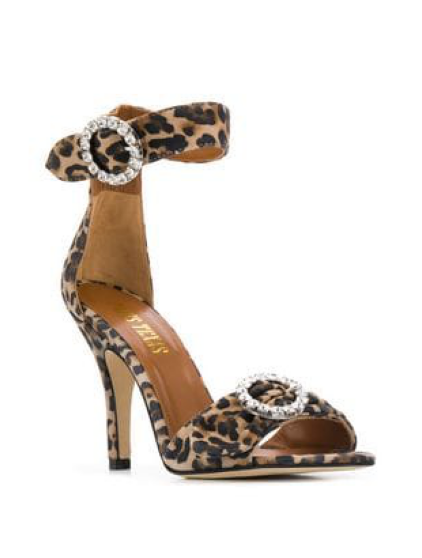


========================================== ResNet Results =============================================


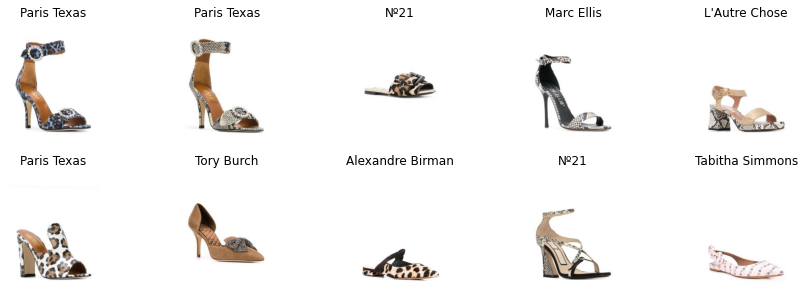



========================================== VGG 16 Results ============================================


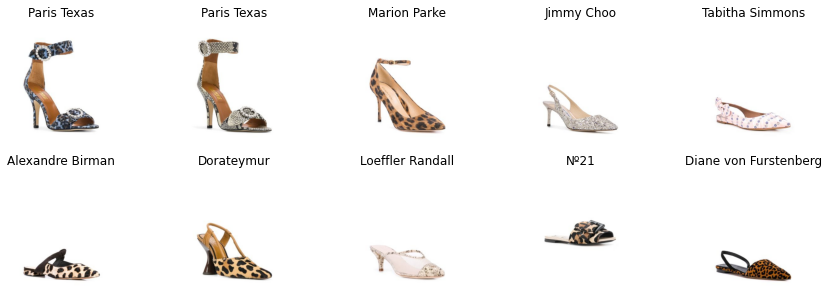



========================================== Xception Results ===========================================


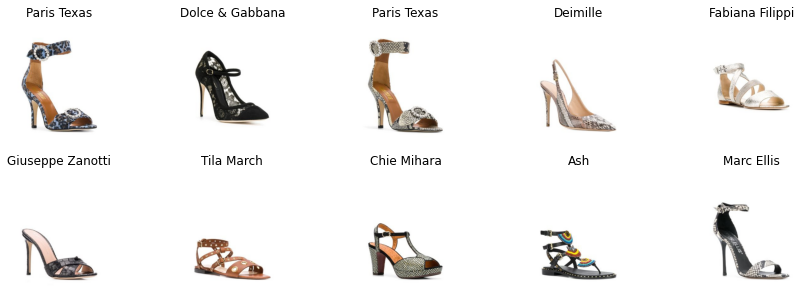

In [159]:
# Plot the results from all three models and prepare a comparison

print("========================================== QUERY IMAGE ===============================================")
plt.figure(figsize=(10,10))
plt.imshow(image.img_to_array(queryImage, dtype='int'))
plt.axis('off')
plt.show()
print("======================================================================================================")
print()

# 1. ResNet
top_10_similar_imgs_Resnet = listing_data.iloc[top_10_indexes_resnet]['modelImages_path']
brand_Resnet = listing_data.iloc[top_10_indexes_resnet]['brand.name']

# 2. VGG 16
top_10_similar_imgs_VGG = listing_data.iloc[top_10_indexes_vgg]['modelImages_path']
brand_VGG = listing_data.iloc[top_10_indexes_vgg]['brand.name']

# 3. Xception
top_10_similar_imgs_Xception = listing_data.iloc[top_10_indexes_xception]['modelImages_path']
brand_Xception = listing_data.iloc[top_10_indexes_xception]['brand.name']

print("========================================== ResNet Results =============================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Resnet, brand_Resnet)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    plt.xlabel(price)
    plt.title(brand)
    plt.axis('off')
plt.show()
print("======================================================================================================")
print()
print()

print("========================================== VGG 16 Results ============================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_VGG, brand_VGG)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    plt.xlabel(price)
    plt.title(brand)
    plt.axis('off')
plt.show()
print("======================================================================================================")
print()
print()

print("========================================== Xception Results ===========================================")
fig = plt.figure(figsize=(15,5))
for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_Xception, brand_Xception)):
    plt.subplot(2, 5, i+1)
    img = image.load_img(img_path)
    img_arr = image.img_to_array(img, dtype='int')
    plt.imshow(img_arr)
    plt.xlabel(price)
    plt.title(brand)
    plt.axis('off') 
plt.show()
print("======================================================================================================")


* It appears all the three architectures are performing similar.

In [146]:
def testModel(img_url):
    
    # Testing the architectures on external images
    
    '''Read the inserted url'''
    img_url = img_url
    response = requests.get(img_url)
    testing_img = Image.open(BytesIO(response.content))
    
    # Using the VGG 16 model to generate similar images
    testing_features = vgg_feature_extractor.extract_features(testing_img)
    
    similarity_images_vgg = {}
    for idx, feat in image_features_vgg.items():

        # Compute the similarity using Euclidean Distance
        similarity_images_vgg[idx] = np.sum((testing_features - feat)**2) ** 0.5

    # Extracting the top 10 similar images
    similarity_vgg_sorted = sorted(similarity_images_vgg.items(), key = lambda x : x[1], reverse=False)
    top_10_indexes_vgg = [idx for idx, _ in similarity_vgg_sorted][ : 10]
    
    # Plotting the images
    top_10_similar_imgs_VGG = listing_data.iloc[top_10_indexes_vgg]['modelImages_path']
    brand_VGG = listing_data.iloc[top_10_indexes_vgg]['brand.name']
    
    print("===================== QUERY IMAGE ==========================")
    plt.figure(figsize=(8,8))
    testing_img_arr = image.img_to_array(testing_img, dtype='int')
    plt.imshow(testing_img_arr)
    plt.axis('off')
    plt.show()
    print("=============================================================")

    fig = plt.figure(figsize=(15,5))
    print("===================== SIMILAR IMAGES ==========================")
    for i, (img_path, brand) in enumerate(zip(top_10_similar_imgs_VGG, brand_VGG)):
        plt.subplot(2, 5, i+1)
        img = image.load_img(img_path)
        img_arr = image.img_to_array(img, dtype='int')
        plt.imshow(img_arr)
        plt.xlabel(price)
        plt.title(brand)
        plt.axis('off')
    plt.show()

===================== QUERY IMAGE ==========================


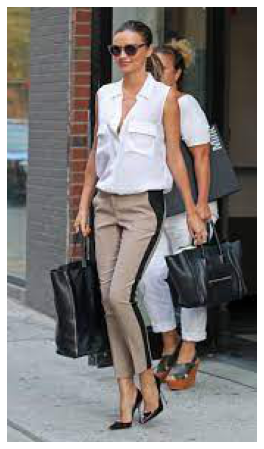

===================== SIMILAR IMAGES ==========================


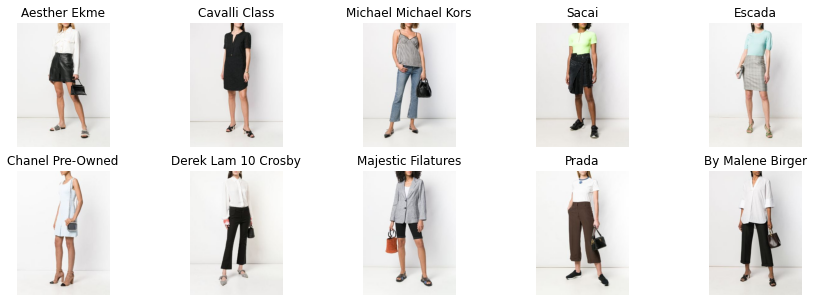

In [147]:
# Call the function
img_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS4wqVGRsgZeFnL9_gJXw2wTfdeRGFEmcKZtV2uvOqn5YYhL1XaHOcIYI1Ya4OFqhfz2kY&usqp=CAU"
testModel(img_url)

===================== QUERY IMAGE ==========================


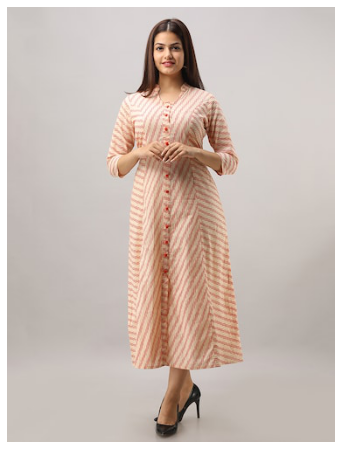

===================== SIMILAR IMAGES ==========================


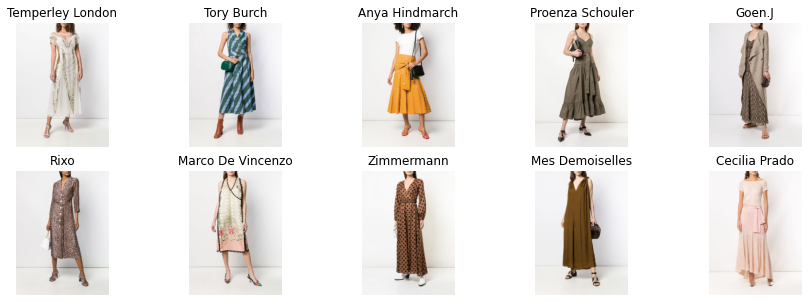

In [148]:
# Call the function
img_url = "https://img3.junaroad.com/uiproducts/16642282/pri_175_p-1598456961.jpg"
testModel(img_url)

===================== QUERY IMAGE ==========================


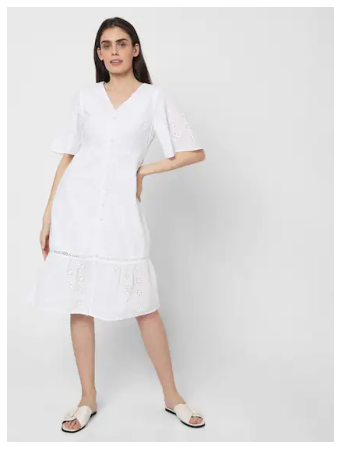

===================== SIMILAR IMAGES ==========================


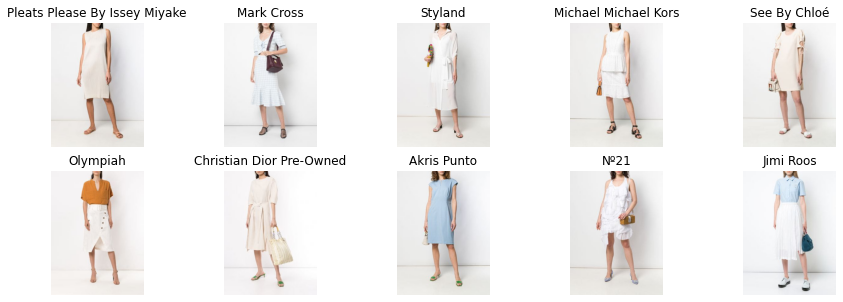

In [149]:
# Call the function
img_url = "https://assets.myntassets.com/f_webp,dpr_2.0,q_60,w_210,c_limit,fl_progressive/assets/images/16517990/2021/12/14/186c22ac-5678-401e-a491-f2f9d58b8aee1639492696377VeroModaWhiteA-LineDress1.jpg"
testModel(img_url)

===================== QUERY IMAGE ==========================


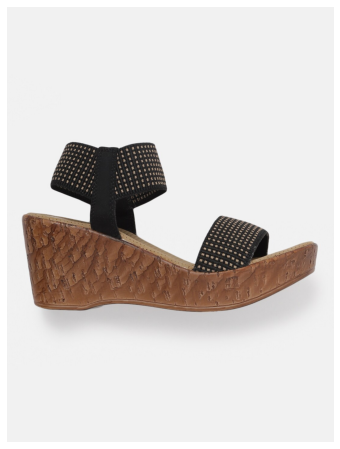

===================== SIMILAR IMAGES ==========================


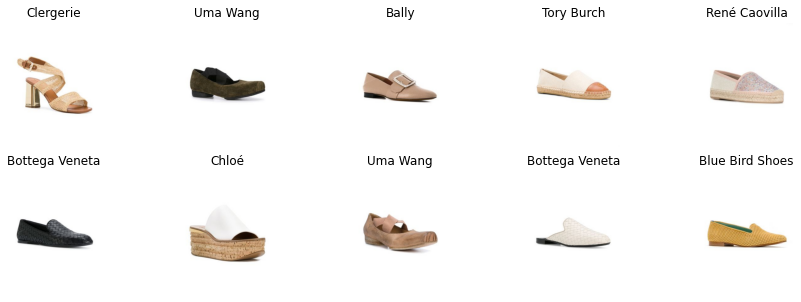

In [150]:
# Call the function
img_url = "https://assets.myntassets.com/h_1440,q_90,w_1080/v1/assets/images/8607853/2021/10/27/3dc9c459-0a09-4a64-8656-c61e762ddb2f1635331357142CatwalkWomenBlackBeigeSolidSandals2.jpg"
testModel(img_url)